In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [5]:
import yaml

config_path = 'config_linear_100_gan_transformer_pca.yaml'
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

In [6]:
train_loss_output_path = 'output_linear_100_1_pca/train_loss_linear_100.npy'
test_loss_output_path = 'output_linear_100_1_pca/test_loss_linear_100.npy'
model_output_path = 'output_linear_100_1_pca/model_linear_100.pth'

In [7]:
train_losses = np.load(train_loss_output_path)
test_losses = np.load(test_loss_output_path)

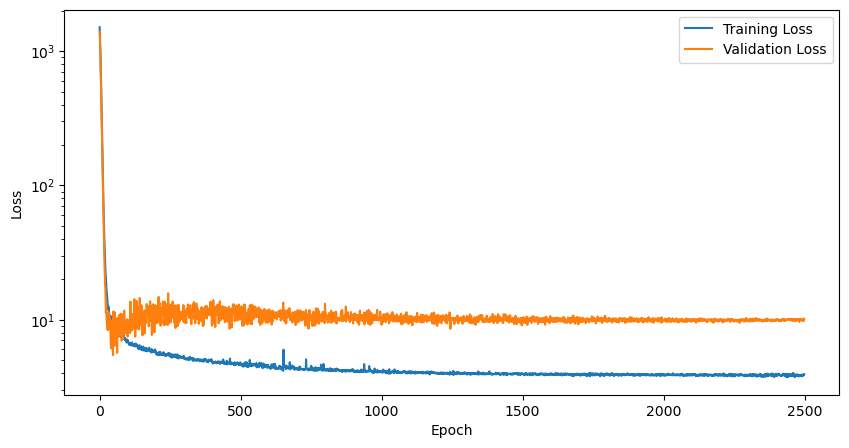

In [8]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

In [9]:
from train import *
import torch
predict_num = 10
train_dataset, test_dataset, n_features, n_inputs = data_preparation_v2_pca(config)
params = Params(n_features, n_inputs)
model = build_model_position_emb(params)
model = torch.load(model_output_path)

['/home/shiqi/code/model_combination_Argos/gan_transformer', '/home/shiqi/anaconda3/envs/torch/lib/python39.zip', '/home/shiqi/anaconda3/envs/torch/lib/python3.9', '/home/shiqi/anaconda3/envs/torch/lib/python3.9/lib-dynload', '', '/home/shiqi/anaconda3/envs/torch/lib/python3.9/site-packages', '../utils']


In [10]:
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

In [11]:
for batch in train_loader:
    x_train, y_train, u1_train, u2_train = batch

In [17]:
y_pred = model(x_train, u1_train, u2_train).detach().numpy()

In [18]:
y_true = y_train.detach().numpy()

In [19]:
err = y_pred - y_true
err_norm = np.linalg.norm(err)
y_true_norm = np.linalg.norm(y_true)
ratio = err_norm / y_true_norm
print(ratio)


0.07875636


In [54]:
predict_num = config['predict_num']
window_size = config['window_size']
data_dir = config['data_dir']
beginning = 50
window_size = window_size - beginning

# Data preparation
x_dataset = []
y_dataset = []
u1_dataset = []
u2_dataset = []


for item in os.listdir(data_dir):
    data_file_path = os.path.join(data_dir, item)

    # Check if the file exists before trying to load it
    if os.path.exists(data_file_path):
        data_dict = np.load(data_file_path, allow_pickle=True).item()
        x_data, y_data, u1_data, u2_data = load_dataset(data_dict, predict_num)
        x_dataset.append(x_data[beginning:beginning+window_size])
        u1_dataset.append(u1_data[beginning:beginning+window_size])
        u2_dataset.append(u2_data[beginning:beginning+window_size])
        y_dataset.append(y_data[beginning:beginning+window_size])
    else:
        print(f"File not found: {data_file_path}")

In [55]:
len(x_dataset)

50

In [56]:
# start from the zero point
x_data_pred_dataset = []
x_data_pca_dataset = []
x_data_pca_pred_dataset = []
for x_data, u1_data, u2_data in zip(x_dataset, u1_dataset, u2_dataset):
    steps = int(window_size / predict_num)
    n_target = x_data.shape[1]
    x_data_scaled = scaler_x.transform(x_data)
    u1_data_scaled = scaler_u.transform(u1_data)
    u2_data_scaled = scaler_u.transform(u2_data)
    x_data_pca = pca.transform(x_data_scaled)
    x_data_pca_dataset.append(x_data_pca)
    x_data_pca_pred = [torch.tensor(x_data_pca[0:predict_num,:], dtype = torch.float32)]
    for step in range(steps - 1):
        # print(step)
        x = torch.tensor(x_data_pca_pred[-1].reshape((1, predict_num, -1)),dtype = torch.float32)
        u1 = torch.tensor(u1_data_scaled[predict_num * step: predict_num * (step + 1), :].reshape((1, predict_num, -1)), dtype = torch.float32)
        u2 = torch.tensor(u2_data_scaled[predict_num * step: predict_num * (step + 1), :].reshape((1, predict_num, -1)), dtype = torch.float32)
        x1 = model(x, u1, u2)
        x_data_pca_pred.append(x1.reshape(predict_num, -1))
    x_data_pca_pred = torch.cat(x_data_pca_pred, dim = 0).detach().numpy()
    x_data_pca_pred_dataset.append(x_data_pca_pred)
    # print(np.shape(y_data_pred_scaled))
    x_data_pred = pca.inverse_transform(x_data_pca_pred)
    x_data_pred = scaler_x.inverse_transform(x_data_pred)
    x_data_pred_dataset.append(x_data_pred)


In [57]:
errors = [x_data_pred_dataset[i] - x_dataset[i][:(steps * predict_num), :] for i in range(len(x_data_pred_dataset))]

cumulative_error_norms = [np.array([np.linalg.norm(errors[i][:j+1,:]) for j in range(errors[i].shape[0])]) for i in range(len(errors))]

data_norms = [np.linalg.norm(x_dataset[i]) for i in range(len(x_dataset))]

relative_errors = [cumulative_error_norms[i] / data_norms[i] for i in range(len(cumulative_error_norms))] 

In [58]:
mean_relative_errors = np.mean(relative_errors, axis=0)
std_relative_errors = np.std(relative_errors, axis=0)   

In [59]:
np.where(np.array(relative_errors)[:, -1]>0.03)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),)

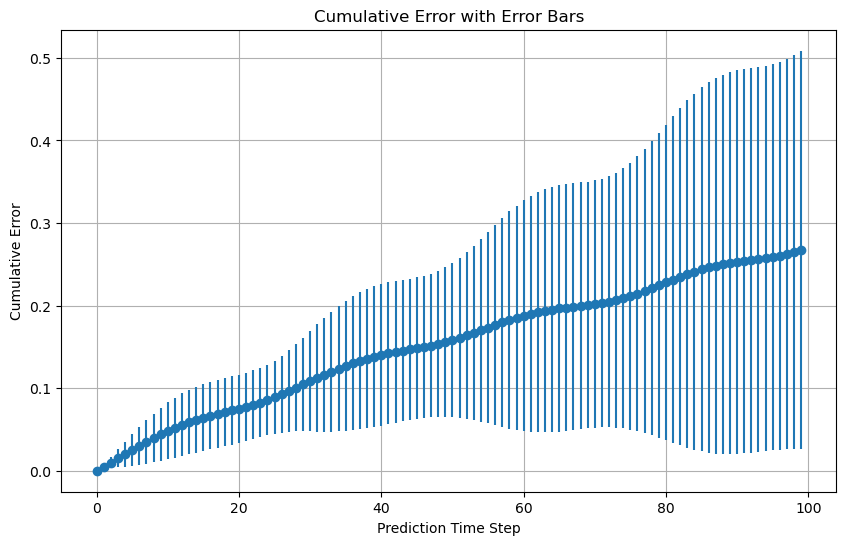

In [60]:
# Plot the relative error with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(range(steps * predict_num), mean_relative_errors, yerr=std_relative_errors, fmt='-o')
plt.xlabel('Prediction Time Step')
plt.ylabel('Cumulative Error')
plt.title('Cumulative Error with Error Bars')
plt.grid(True)
plt.show()

In [61]:
domain_error_norms = [np.linalg.norm(errors[i]) for i in range(len(x_dataset))]
domain_relative_error = [domain_error_norms[i]/data_norms[i] for i in range(len(domain_error_norms))]

In [62]:
np.mean(domain_relative_error)

0.26718147123847763

In [63]:
np.std(domain_relative_error)

0.24142489285469185

In [64]:
x_dataset[0].shape

(100, 6957)

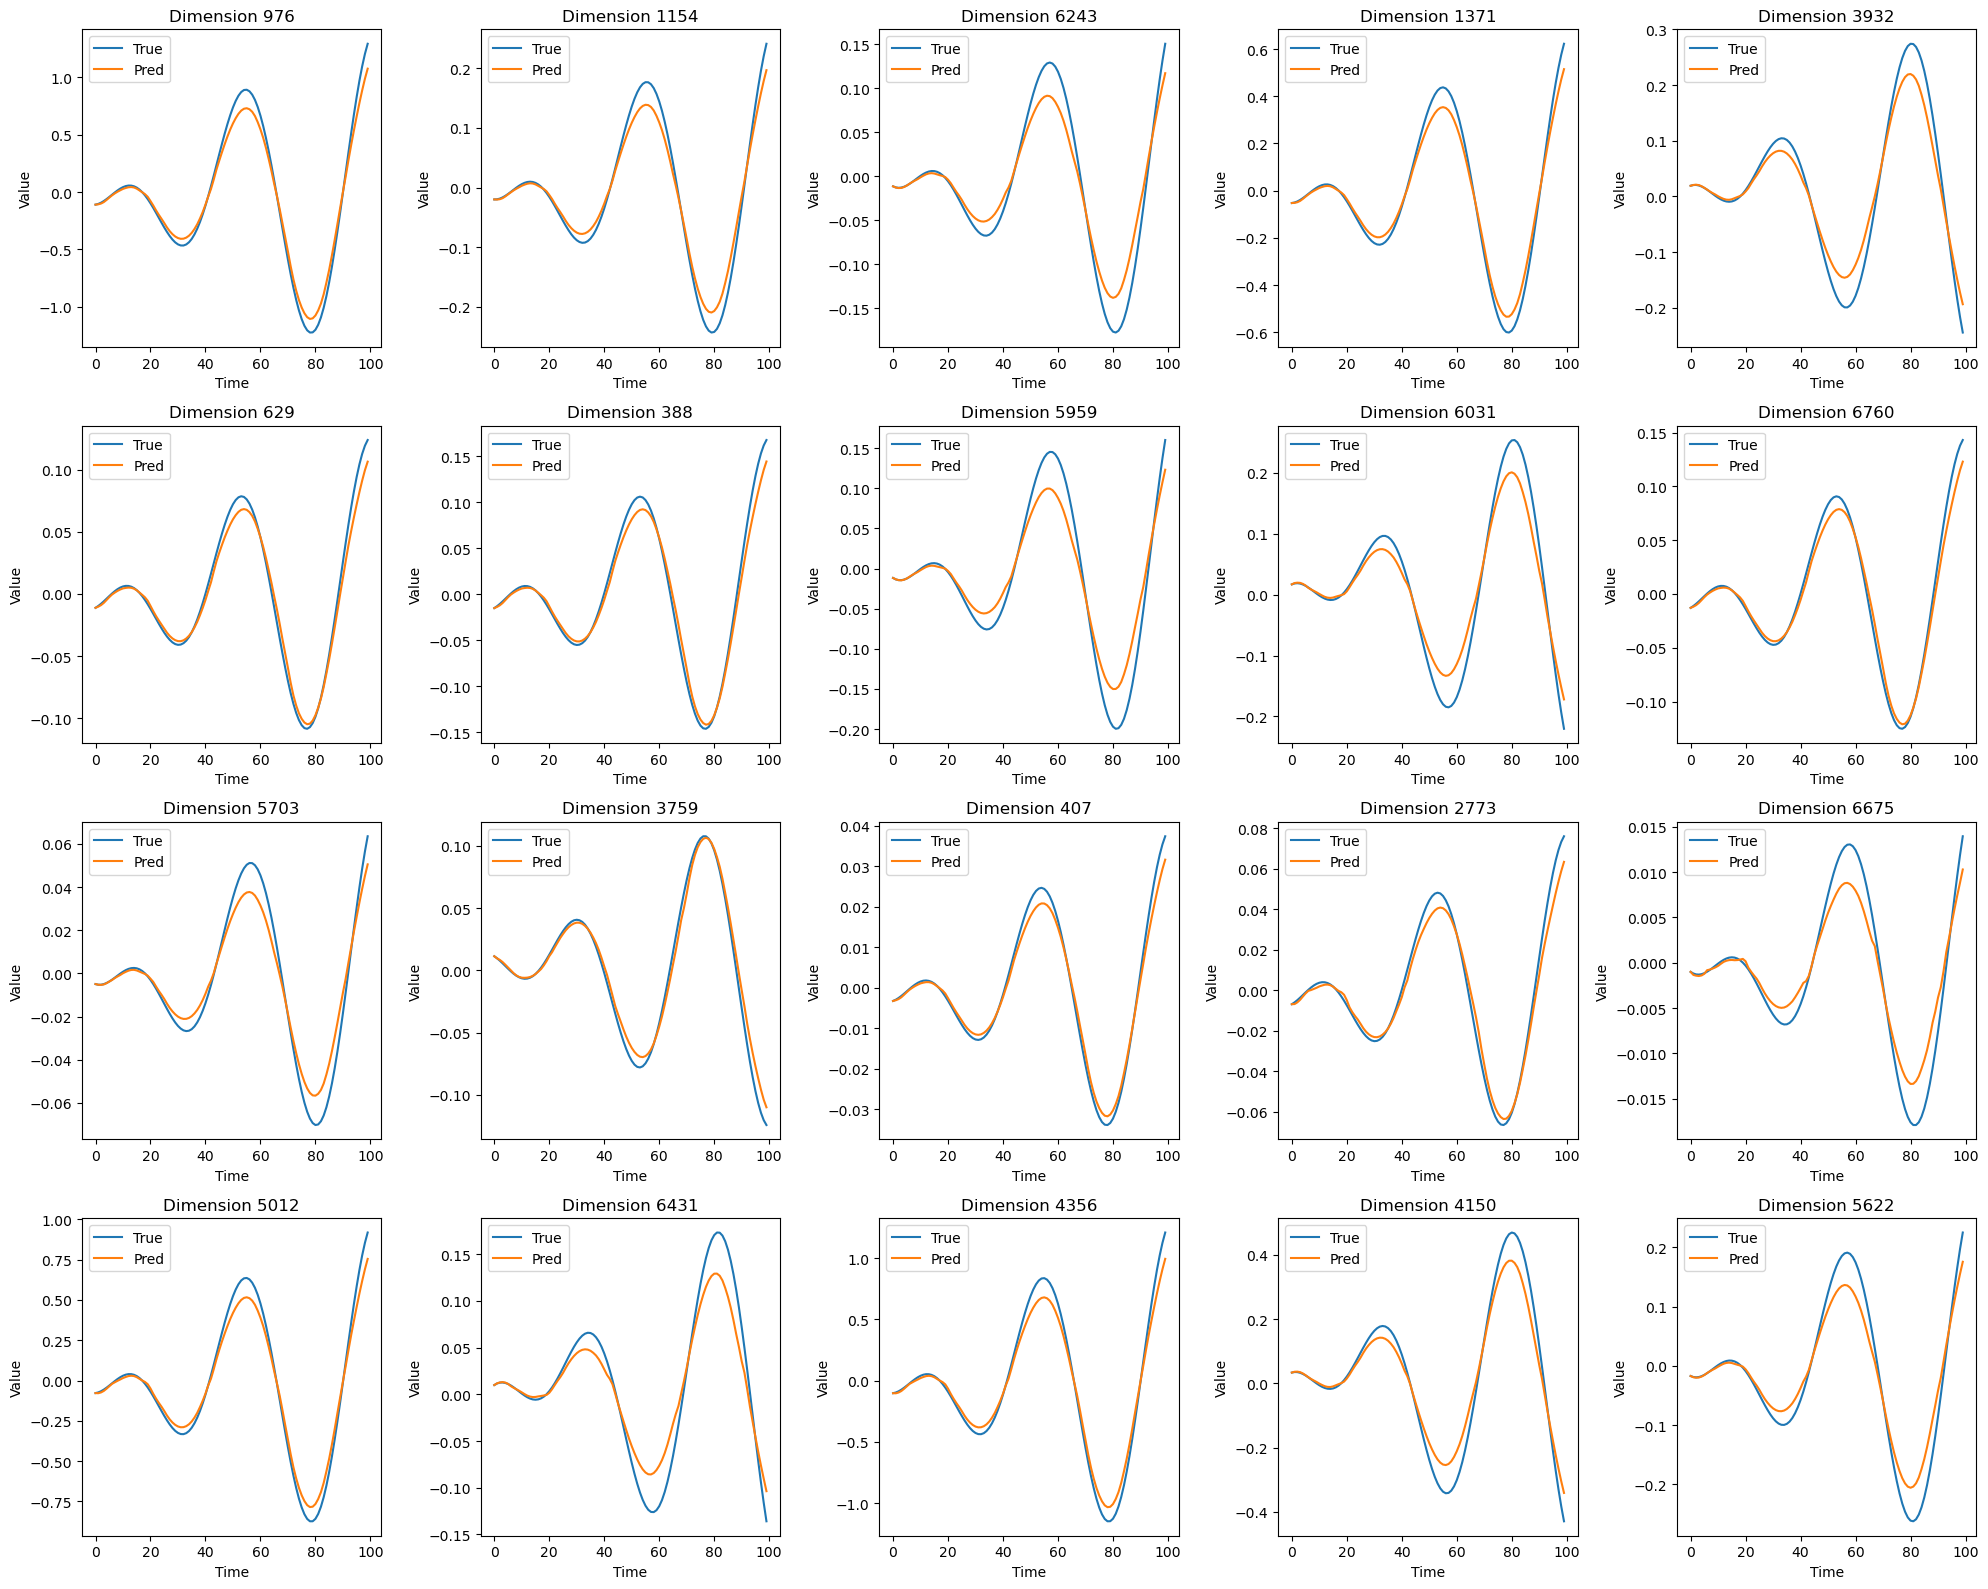

In [66]:
import numpy as np
import matplotlib.pyplot as plt

k = 0  # 假设你已经有了一个数据集索引
n_dimensions = x_dataset[k].shape[1]  # 假设x_dataset[k]是你的数据
selected_dimensions = np.random.choice(n_dimensions, 20, replace=False)  # 随机选择20个维度

# 设置一个4x5的子图网格
fig, axs = plt.subplots(4, 5, figsize=(20, 16))  # 调整figsize根据你的需求

# 确保x_true和x_pred已经根据k正确加载
x_true = x_dataset[k]
x_pred = x_data_pred_dataset[k]

# 遍历所有选定的维度
for idx, dim in enumerate(selected_dimensions):
    # 计算行号和列号
    row = idx // 5
    col = idx % 5
    
    # 在对应的子图上绘图
    axs[row, col].plot(x_true[:, dim], label='True')
    axs[row, col].plot(x_pred[:, dim], label='Pred')
    axs[row, col].set_title(f'Dimension {dim}')
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Value')
    axs[row, col].legend()

# 调整布局以防止标签重叠
plt.tight_layout()
plt.show()


In [67]:
len(x_data_pca_pred_dataset)

50

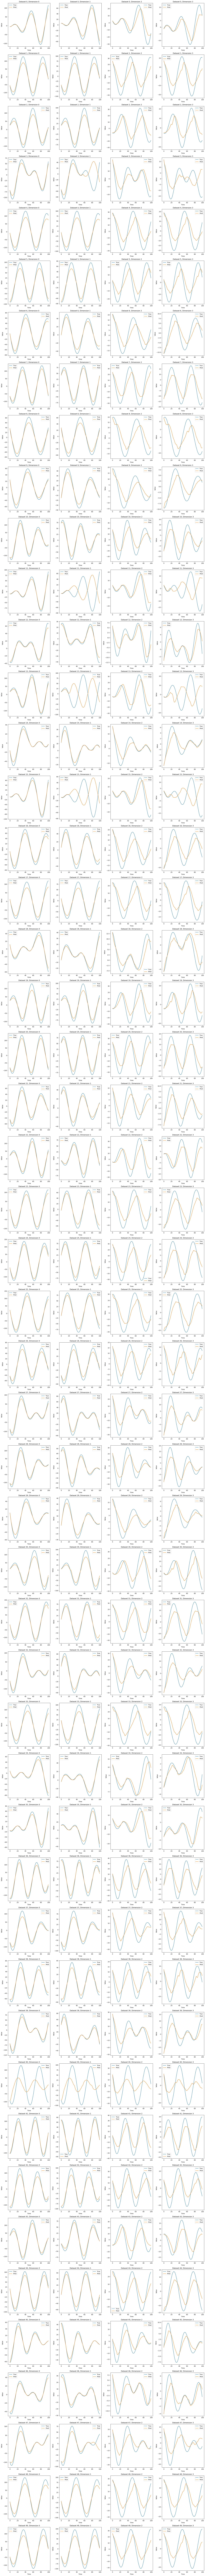

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming x_data_pca_dataset and x_data_pca_pred_dataset are your loaded datasets

# Create a large figure
fig, axs = plt.subplots(50, 4, figsize=(20, 250))  # Note: This will create 200 plots!

for k in range(50):  # Iterate through the first 50 datasets
    x_true = x_data_pca_dataset[k]
    x_pred = x_data_pca_pred_dataset[k]

    for dim in range(4):
        # Plot for the first 4 dimensions of each dataset
        ax = axs[k, dim]
        ax.plot(x_true[:, dim], label='True')  # Plot true values
        ax.plot(x_pred[:, dim], label='Pred')  # Plot predicted values
        ax.set_title(f'Dataset {k}, Dimension {dim}')  # Set title
        ax.set_xlabel('Time')  # Set x-axis label
        ax.set_ylabel('Value')  # Set y-axis label
        ax.legend()  # Show legend

plt.tight_layout()  # Adjust layout
plt.show()  # Display the figure
